<a id='top'></a>
# Adversarial examples on images generated by 2D Cellular Automaton
----
## Table of Content
----

<a href='#section1'>1. Introduction</a>

<a href='#section2'>2. Cellular Automaton</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section2.1'>2.1. Cellular Automaton engine</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section2.2'>2.2. Evolution rules</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section2.2'>2.3. Testing automatas</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section2.3.1'>2.3.1. Conway's Game of Life</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section2.3.2'>2.3.2. High Life</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section2.3.3'>2.3.3. Mathematical 2D-CA model (linear rules)</a>

<a href='#section3'>3. Image generation</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section3.1'>3.1. Generated image analysis</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section3.2'>3.2. Approach #1: Binary Classification</a>

<a href='#section4'>4. Loading the images</a>

<a href='#section5'>5. Defining the model</a>

<a href='#section6'>6. Training the model</a>

<a href='#section7'>7. Check model's performance</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section7.1'>7.1. Test prediction visualization</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section7.2'>7.2. Metrics</a>

<a href='#section8'>8. Other approaches</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section8.1'>8.1. Approach #2: 120 samples per class, 9-class classsification</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#section8.2'>8.2. Approach #3: 60 samples per class, 9-class classsification</a>

<a href='#section9'>9. Adversarial perturbations</a>

----

<a id='section1'></a>
## 1. Introduction
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

Cellular automata are mathematical models for systems in which many simple components act together to produce complicated patters of behavior.

A cellular automaton consists of a regular lattice of sites. Each site takes on $k$ possible values, and is updated in discrete time steps according to a rule $\phi$ that depends on the values of sites in some neighborhood around it.

There are several possible lattices and neighborhood structures for two-dimensional cellular automata. For example, five-neighbor (von Neumann) square cellular automaton then evolves according to:

$$a_{i,j}^{(t+1)}=\phi[a_{i,j}^{(t)}, a_{i,j+1}^{(t)}, a_{i+1,j}^{(t)}, a_{i,j-1}^{(t)}, a_{i-1,j}^{(t)}]$$

| ![von Neumann Neighborhood](res/vonNeumann.png) | ![Moore Neighborhood](res/Moore.png) |
| :--: | :--: |
| *von Neumann neighborhood* | *Moore neighborhood* |

__Source__: [Packard, N.H., Wolfram, S. Two-dimensional cellular automata. J Stat Phys 38, 901–946 (1985).](https://content.wolfram.com/uploads/sites/34/2020/07/two-dimensional-cellular-automata.pdf)


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import random, os, copy

plt.rcParams["animation.html"] = "html5"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

<a id='section2' style='display: none;'></a>
## 2. Cellular Automaton
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

<a id='section2.1'></a>
### 2.1. Cellular Automaton engine
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

For sure this is not the most efficient implementation of 2D-CA. Code optimization has not been performed, left as future work.

In [2]:
class BinaryCellularAutomaton:
    
    '''
    Class representing the Cellular Automaton with k = 2 (binary).
    
      - Rows (int): represents the number of rows of the cellular automata.
      - Cols (int): represents the number of columns of the cellular automata.
      - evolution_rule (callable): rule to apply each timestep by the cellular automata.
                                   Takes as input a 9x9 matrix, and returns a single value.
      - neighborhood (str): Either 'von Neumann' or 'Moore'.
      - seed (ndarray, optional): matrix of shape (timesteps + 1, rows, cols) indicating the inital 
                                  state of the automaton at slice [0, :, :]. If not passed, the seed is random.
      - timesteps (int, optional): represents the total number of steps to evolve the CA.
      - rule_idx (int, optional): represents the rule number to apply, when EvolutionRules.rule_idx
    '''
    
    def __init__(self, rows, cols, evolution_rule, neighborhood, seed=None, timesteps=50, rule_idx=None):
        if neighborhood not in ['von Neumann', 'Moore']:
            raise Exception('Invalid neighborhood type. Valid types are "von Neumann" and "Moore".')
            
        if not callable(evolution_rule):
            raise Exception('Invalid evolution_rule. It should be a callable function.')
        
        seed = None if seed is None else np.copy(seed)
        self.ca = np.random.randint(2, size=(timesteps, rows, cols), dtype=np.bool) if seed is None or seed.shape[1:] != (rows, cols) else seed
        self.evolution_rule = evolution_rule
        self.rule_idx = rule_idx
        self.neighborhood = neighborhood
        self.timesteps = timesteps
    
    # This is a Null-boundary neighborhood
    def _get_neighborhood(self, row, col, timestep=-1):        
        neighborhood = np.zeros((3,3), dtype=np.bool)
        
        for i in range(row - 1, row + 2):
            if i >= 0 and i < self.ca.shape[1]:
                for j in range(col - 1, col + 2):
                    if j >= 0 and j < self.ca.shape[2]:
                        neighborhood[i - row + 1, j - col + 1] = self.ca[timestep, i, j]
                        
        von_neumann_mask = [[False, True, False], [True, True, True], [False, True, False]]
        
        return neighborhood if self.neighborhood == 'Moore' else neighborhood * von_neumann_mask
    
    def evolve(self, use_tqdm=True):
        r = tqdm(range(self.timesteps - 1)) if use_tqdm else range(self.timesteps - 1)
        for t in r:
            for i in range(self.ca.shape[1]):
                for j in range(self.ca.shape[2]):
                    self.ca[t+1, i, j] = self.evolution_rule(self._get_neighborhood(i,j,timestep=t), 
                                                             idx=self.rule_idx)
        
    def animate(self):
        fig = plt.figure(figsize=(3,3))
        ax = plt.axes()
        i = 0
        im = ax.imshow(np.abs(1 - self.ca[i, :, :]), cmap=plt.cm.gray, vmin=0, vmax=1, animated=True)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        
        # Code taken from: https://stackoverflow.com/questions/50413680/matplotlib-animate-2d-array
        def updatefig(*args):
            nonlocal i, self
            if (i<self.timesteps - 1):
                i += 1
            else:
                i=0
            im.set_array(np.abs(1 - self.ca[i]))
            return im,
        
        anim = animation.FuncAnimation(fig, updatefig,  blit=True)
        plt.close()
        
        return anim
    
    def draw(self, timestep=-1):
        plt.figure(figsize=(3,3))
        ax = plt.axes()
        ax.imshow(np.abs(1 - self.ca[timestep - 1, :, :]), cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.suptitle(f'Timestep {timestep if timestep != -1 else self.timesteps}', fontsize=8)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        plt.show()
        plt.close()
    
    def savefig(self, filename, timestep=-1):
        plt.imsave(filename, np.abs(1 - self.ca[timestep, :, :]), cmap=plt.cm.gray, vmin=0, vmax=1)
        

<a id='section2.2'></a>
### 2.2. Evolution rules
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

In [3]:
class EvolutionRules:    
    @staticmethod
    def game_of_life(neighborhood, **kwargs):
        alive_neighbors = np.sum(neighborhood) - neighborhood[1,1]
        if neighborhood[1,1]:
            return False if alive_neighbors < 2 or alive_neighbors > 3 else True
        elif alive_neighbors == 3:
            return True
        else:
            return False
    
    @staticmethod
    def high_life(neighborhood, **kwargs):
        alive_neighbors = np.sum(neighborhood) - neighborhood[1,1]
        if neighborhood[1,1]:
            return False if alive_neighbors < 2 or alive_neighbors > 3 else True
        elif alive_neighbors == 3 or alive_neighbors == 6:
            return True
    
    @staticmethod
    def rule_idx(neighborhood, idx=-1):
        # Only applicable with Moore's neighborhood (https://arxiv.org/pdf/0804.2346.pdf)
        
        cell_index_map = [(1, 1), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2)]
        c = 0
        if idx > 0 and idx <= 512:
            bin_repr = format(idx, 'b')
            for i, (x,y) in zip(reversed(bin_repr), cell_index_map):
                if i == '1' and neighborhood[x, y]:
                    c += 1
            return c % 2 != 0
        else:
            raise ValueError("Rule number out of range.")
    
    @staticmethod
    def rule_idx_group(idx):
        return sum([int(i) for i in format(idx, 'b')])

<a id='section2.3'></a>
### 2.3. Testing Automatas
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

<a id='section2.3.1'></a>
#### 2.3.1. Conway's Game of Life
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

__RULES__:
1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

In [4]:
ca = BinaryCellularAutomaton(50, 50, EvolutionRules.game_of_life, 'Moore')
ca.evolve()

100%|██████████| 49/49 [00:01<00:00, 32.74it/s]


In [5]:
anim = ca.animate()

In [6]:
anim

<a id='section2.3.2'></a>
#### 2.3.2. High Life
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

Similar to Conway's Game of Life, but Nathan Thompson discovered an interesting pattern with this slight modification of the original rules, called the replicator.

1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three __or six__ live neighbours becomes a live cell, as if by reproduction.

| ![The Replicator](res/replicator.png) |
| :--: |
| The Replicator. Herbee, Public domain, via Wikimedia Commons |

In [7]:
seed = np.zeros((100, 50, 50), dtype=np.bool)
seed[0, 24, 22] = True
seed[0, 25, 22] = True
seed[0, 26, 22] = True
seed[0, 26, 23] = True
seed[0, 26, 24] = True
seed[0, 25, 25] = True
seed[0, 24, 26] = True
seed[0, 23, 26] = True
seed[0, 22, 26] = True
seed[0, 22, 25] = True
seed[0, 22, 24] = True
seed[0, 23, 23] = True

ca = BinaryCellularAutomaton(50, 50, EvolutionRules.high_life, 'Moore', seed=seed, timesteps=100)
ca.evolve()

100%|██████████| 99/99 [00:03<00:00, 29.68it/s]


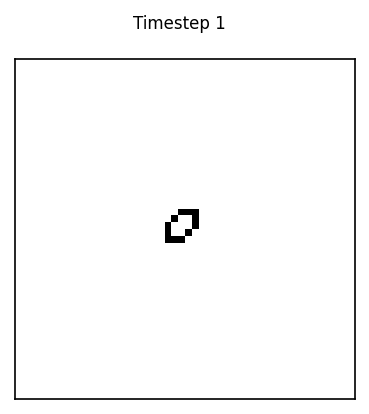

In [8]:
ca.draw(timestep=1)

In [9]:
anim = ca.animate()

In [10]:
anim

<a id='section2.3.3'></a>
#### 2.3.3. Mathematical 2D-CA model (linear rules)
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

In [Theory and Applications of Two-dimensional, Null-boundary, Nine-Neighborhood, Cellular Automata Linear rules](https://arxiv.org/pdf/0804.2346.pdf), 2D-CA linear rules are defined as follows: taking into account the cell codification below, there are $2^9=512$ different linear rules (that can be applied by XOR operator). 

E.g. rule 246 is codified as $011110110$, this mask is then applied to each neighborhood, following the cell order defined in the following table.

In this work, we apply each rule uniformly to each neighborhood with a null-boundary (padding o logical value if needed).

<table>
    <tfoot><tr><td colspan="3">Binary digit codification of Moore's neighborhood.</td></tr></tfoot>
    <tbody>
      <tr>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>&#8205; 64</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>128</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>256</td>
      </tr>
      <tr>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>32</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>1</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>2</td>
      </tr>
      <tr>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>16</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>8</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>4</td>
      </tr>
    </tbody>
</table>

These rules are grouped into nine groups in the following manner. Group $N$ for $N = 1, 2, \ldots , 9$, includes the rules that refer to the dependency of current cell on the $N$ neighboring cells amongst top, left, bottom, right, top-left, top-right, bottom-left, bottom-right and itself. It can be noted that number of 1’s present in the binary sequence of a rule is same as its group number. 

Previously named rule 246 then belongs to group 6.

<table>
    <tfoot><tr><td colspan="3">Graphical representation of rule 246.</td></tr></tfoot>
    <tbody>
      <tr>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>1</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>1</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>0</td>
      </tr>
      <tr>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>1</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>0</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>1</td>
      </tr>
      <tr>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>1</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>0</td>
        <td style='border: 1px solid #000; text-align: center; vertical-align: middle;'>1</td>
      </tr>
    </tbody>
</table>

In [11]:
seed = np.zeros((50, 50, 50), dtype=np.bool)
seed[0,24,24] = True

ca = BinaryCellularAutomaton(50,50, EvolutionRules.rule_idx, 'Moore', rule_idx=246, seed=seed)
ca.evolve()

100%|██████████| 49/49 [00:00<00:00, 52.61it/s]


In [12]:
anim = ca.animate()

In [13]:
anim

<a id='section3'></a>
## 3. Image Generation
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

We will generate images using the previously defined 512 linear 2D-CA rules. Like this we can group them in 9 different classes so that we can afterwards define a 9-class classification problem.

__NOTE__: be careful when executing next cell for the first time, it takes around 30 minutes to execute.

In [14]:
try:
    os.mkdir('images')
    os.mkdir('images/raw')
    
    for i in range(1,10,1):
        os.mkdir(f'images/raw/{i}')
    
    seed = np.zeros((50, 100, 100), dtype=np.bool)
    seed[0,24,24] = True

    for idx in tqdm(range(1, 513, 1)):
        ca = BinaryCellularAutomaton(100, 100, EvolutionRules.rule_idx, 'Moore', rule_idx=idx, seed=seed)
        ca.evolve(use_tqdm=False)
        ca.savefig(f'images/raw/{EvolutionRules.rule_idx_group(idx)}/{idx}.png')
except FileExistsError:
    print('Images corresponding to the execution of the 512 rules already exist!')

Images corresponding to the execution of the 512 rules already exist!


<a id='section3.1'></a>
### 3.1. Generated image analysis
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

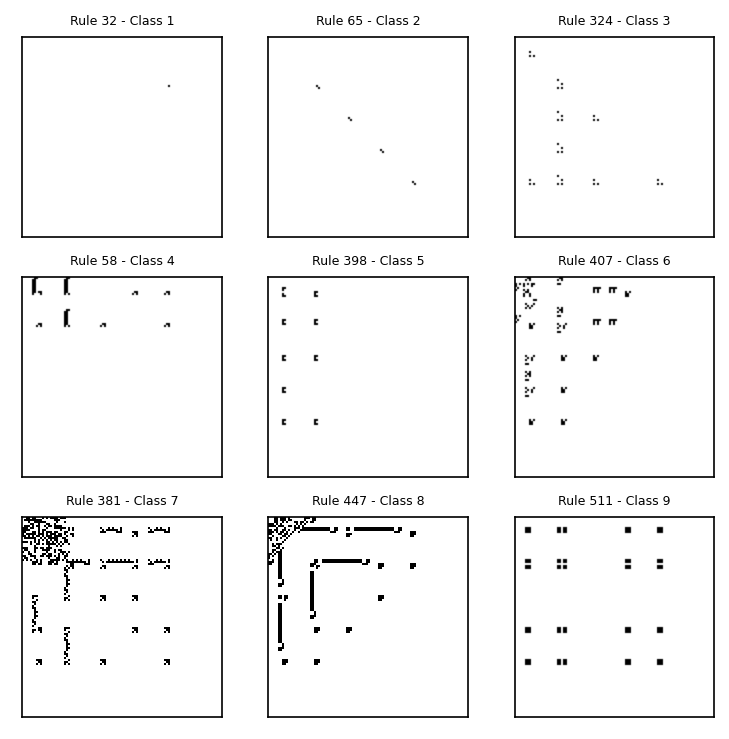

In [15]:
plt.figure(figsize=(6,6))

for i in range(1,10,1):
    path_name = f'images/raw/{i}'
    image_name = random.choice(os.listdir(path_name))
    ax = plt.subplot(3,3,i)
    ax.imshow(mpimg.imread(f'{path_name}/{image_name}'))
    ax.set_title(f'Rule {image_name[:-4]} - Class {EvolutionRules.rule_idx_group(int(image_name[:-4]))}', fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()
plt.close()

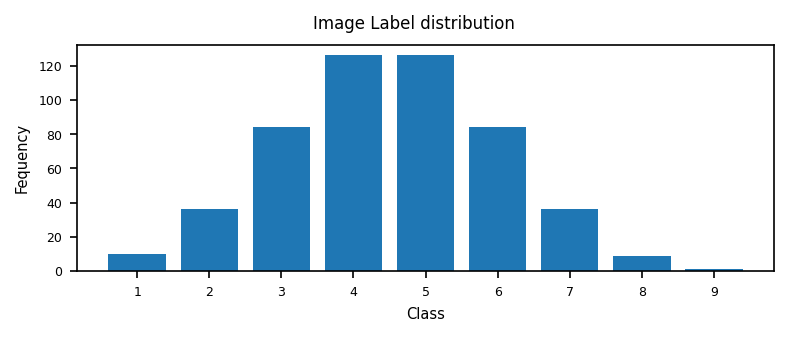

In [16]:
def show_label_distribution(path_name, num_labels):
    counts = []
    for i in range(1,num_labels + 1,1):
        counts.append(len(os.listdir(f'{path_name}/{i}')))

    plt.figure(figsize=(6,2))
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.bar(range(1,num_labels + 1,1), counts)
    plt.xticks(range(1,num_labels + 1,1))
    plt.suptitle('Image Label distribution', fontsize=8)
    plt.xlabel('Class', fontsize=7)
    plt.ylabel('Fequency', fontsize=7)
    plt.show()
    plt.close()

show_label_distribution('images/raw', 9)

<a id='approaches'></a>
- As it can be seen, the amount of images per class varies dramatically from class to class. This is a consequence of the way rules are defined.
- Probably, the most effective way of building a classification problem is to first balance our data.

- From here, there are different __approaches__:
  1. Convert the problem from 9-class classification to binary classification ($\leq 4$ and $\geq 5$).
  2. Balance classes using different seeds to get 120 examples per class.
  3. Set maximum examples per class to some number less than 120, discard examples from classes that exceed the limit, and generate new samples with different seeds for classes that don't reach the limit.

<a id='section3.2'></a>
### 3.2. Approach #1: Binary Classification
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

We will use symlinks in order to save disk space.

In [17]:
try:
    os.mkdir('images/approach_1')
    os.mkdir('images/approach_1/1')
    os.mkdir('images/approach_1/2')

    dst_path_name = 'images/approach_1/1'
    for i in range(1,10,1):
        src_path_name = f'images/raw/{i}'
        if i == 5:
            dst_path_name = 'images/approach_1/2'
        for i in os.listdir(src_path_name):
            os.symlink(os.path.realpath(f'{src_path_name}/{i}'), f'{dst_path_name}/{i}')
except FileExistsError:
    print('Approach 1 data already generated!')

Approach 1 data already generated!


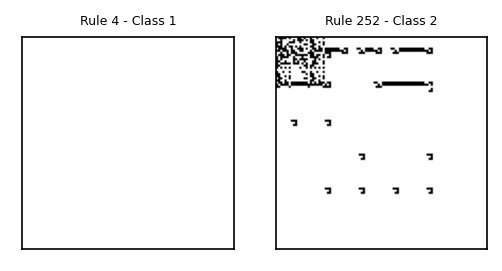

In [18]:
plt.figure(figsize=(4,4))
for i in range(1,3,1):
    path_name = f'images/approach_1/{i}'
    image_name = random.choice(os.listdir(path_name))
    ax = plt.subplot(1,2,i)
    ax.imshow(mpimg.imread(os.path.realpath(f'{path_name}/{image_name}')))
    ax.set_title(f'Rule {image_name[:-4]} - Class {i}', fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
plt.close()

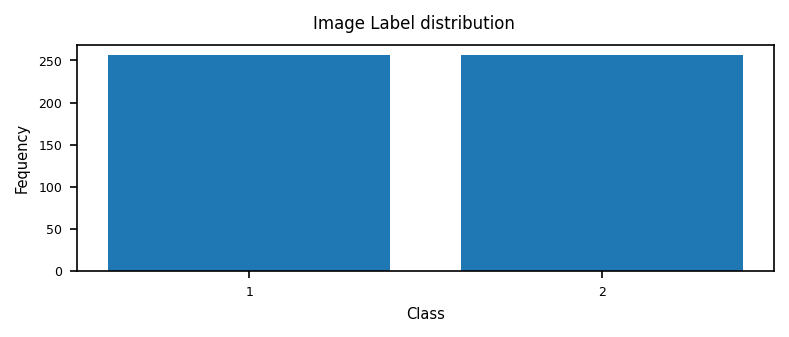

In [19]:
show_label_distribution('images/approach_1', 2)

<a id='section4'></a>
## 4. Loading the images
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

In [20]:
images_root_path = 'images/approach_1'
train_ratio = 0.8

In [21]:
def image_loader(filename):
    rgba_img = Image.open(filename).convert('L')
    assert rgba_img.size == (100,100)
    return rgba_img

As we load images, we also apply random transformations to images (data augmentation). 

Data augmentation is useful only when training, so we split the dataset into two dataloaders, one performing random transformations to images, and the other reading images as they are originally.

In [31]:
data_augmentation = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=(-15,15), 
                            translate=(0.05,0.05), 
                            scale=(0.95, 1.05), 
                            shear=(-15, 15, -15, 15),
                            fillcolor=127),
    transforms.ToTensor()
])

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

augmented_data = ImageFolder(root=images_root_path, transform=data_augmentation, loader=image_loader) # This will be used for training
original_data = ImageFolder(root=images_root_path, transform=tensor_transform, loader=image_loader)   # This will be used for testing

sss = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio)
train_idx, test_idx = next(sss.split(original_data, original_data.targets))
train_dataloader = DataLoader(Subset(augmented_data, train_idx), shuffle=True, batch_size=4)
test_dataloader = DataLoader(Subset(original_data, test_idx), shuffle=True, batch_size=4)

<a id='section5'></a>
## 5. Defining the model
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

In [32]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 23 * 23, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 23 * 23)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [33]:
net = ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8464, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


<a id='section6'></a>
## 6. Training the model
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

In [34]:
def calculate_acc(data, model, device=None, loss_func=None, return_preds=False):
    correct = 0
    total = 0
    running_loss = 0.0
    preds = torch.BoolTensor([]).to(device)
    y_true = torch.BoolTensor([]).to(device)
    
    with torch.no_grad():
        for i, d in enumerate(data):
            images, labels = d
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.view(-1) > 0.5
            if return_preds:
                preds = torch.cat((preds, torch.flatten(predicted)), 0)
                y_true = torch.cat((y_true, labels), 0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if loss_func is not None:
                running_loss += loss_func(outputs, labels.view(-1,1).to(torch.float32)).item()
    
    if return_preds:
        return 100 * correct / total, running_loss / len(data), (y_true.cpu(), preds.cpu())
    
    return 100 * correct / total, running_loss / len(data)

In [35]:
def train(train_data, test_data, model, epochs, loss_func, optimizer, device, print_freq=50, early_stop=False):
    train_accuracies = []
    test_accuracies = []

    train_losses = []
    test_losses = []
    
    increasing_loss_count = 0
    last_model_state_dict = None

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_data):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_func(outputs, labels.view(-1,1).to(torch.float32))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % print_freq == print_freq - 1:    # print every 50 mini-batches
                train_acc, _ = calculate_acc(train_data, model, device=device)
                test_acc, test_loss = calculate_acc(test_data, model, loss_func=loss_func, device=device)

                print('[%d, %5d] train_loss: %.5f train_acc: %.5f test_loss: %.5f test_acc: %.5f' %
                      (epoch + 1, i + 1, running_loss / 50, train_acc, test_loss, test_acc))
                
                if early_stop:
                    if len(test_losses) > 0 and test_loss > test_losses[-1]:
                        increasing_loss_count += 1
                    else:
                        increasing_loss_count = 0
                        last_model_state_dict = copy.deepcopy(model.state_dict())
                        
                    # if test loss increases 5 times in a row, we stop and revert model to previous state
                    if increasing_loss_count > 2: 
                        print('\nModel started to overfit, training stopped.')
                        model.load_state_dict(last_model_state_dict)
                        increasing_loss_count -= 1
                        return (train_losses[:-increasing_loss_count], test_losses[:-increasing_loss_count]), \
                               (train_accuracies[:-increasing_loss_count], test_accuracies[:-increasing_loss_count])

                train_losses.append(running_loss / 50)
                test_losses.append(test_loss)
                train_accuracies.append(train_acc)
                test_accuracies.append(test_acc)
                running_loss = 0.0

    print('\nFinished Training')
    return (train_losses, test_losses), (train_accuracies, test_accuracies)

<a id='section7'></a>
## 7. Check model's performance
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

In [38]:
net = ConvNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

(train_losses, test_losses), (train_accuracies, test_accuracies) = train(train_dataloader, test_dataloader, net, 300, criterion, optimizer, device)

[1,    50] train_loss: 0.70261 train_acc: 49.87775 test_loss: 0.69484 test_acc: 50.48544
[1,   100] train_loss: 0.69685 train_acc: 50.12225 test_loss: 0.69500 test_acc: 49.51456
[2,    50] train_loss: 0.69129 train_acc: 50.12225 test_loss: 0.69257 test_acc: 49.51456
[2,   100] train_loss: 0.69578 train_acc: 67.97066 test_loss: 0.69010 test_acc: 78.64078
[3,    50] train_loss: 0.69256 train_acc: 53.05623 test_loss: 0.68714 test_acc: 51.45631
[3,   100] train_loss: 0.68564 train_acc: 50.12225 test_loss: 0.70158 test_acc: 49.51456
[4,    50] train_loss: 0.69044 train_acc: 50.12225 test_loss: 0.69916 test_acc: 49.51456
[4,   100] train_loss: 0.70309 train_acc: 50.12225 test_loss: 0.68420 test_acc: 49.51456
[5,    50] train_loss: 0.68303 train_acc: 81.66259 test_loss: 0.67154 test_acc: 82.52427
[5,   100] train_loss: 0.66686 train_acc: 50.12225 test_loss: 0.69643 test_acc: 49.51456
[6,    50] train_loss: 0.66306 train_acc: 80.92910 test_loss: 0.63821 test_acc: 85.43689
[6,   100] train_loss

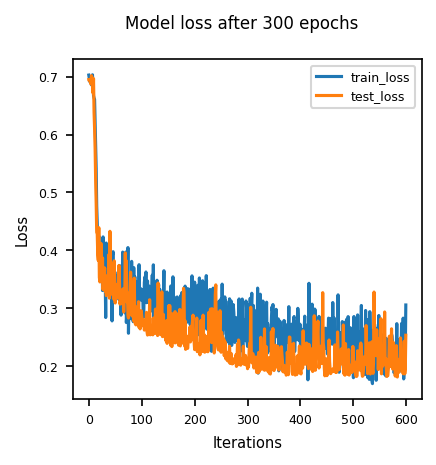

In [40]:
plt.figure(figsize=(3,3))
plt.tick_params(axis='both', which='major', labelsize=6)
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend(prop={'size': 6})
plt.suptitle('Model loss after 300 epochs', fontsize=8)
plt.xlabel('Iterations', fontsize=7)
plt.ylabel('Loss', fontsize=7)
plt.show()

<a id='section7.1'></a>
### 7.1. Test prediction visualization
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

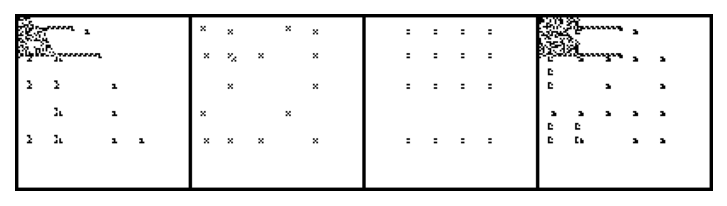

GroundTruth:      1     1     0     1
Predicted:        1     0     0     1


In [49]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
img = make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()
plt.close()
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))
outputs = net(images.to(device))
predicted = outputs > 0.5
print('Predicted:   ', ' '.join('%5s' % int(predicted[j].item()) for j in range(4)))

<a id='section7.2'></a>
### 7.2. Metrics
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

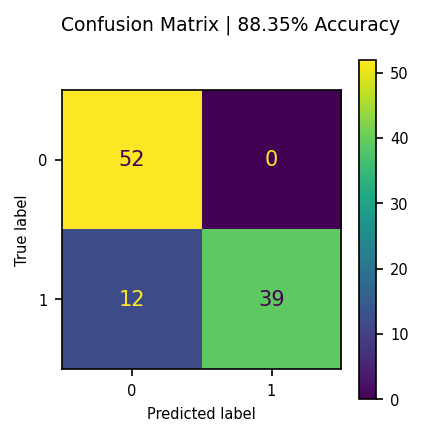

In [50]:
acc, _, (y_true, preds) = calculate_acc(test_dataloader, net, device=device, return_preds=True)
conf_matrix = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(3,3))
ax = plt.gca()
disp.plot(ax=ax)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.images[-1].colorbar.ax.get_yticklabels()):
    item.set_fontsize(7)

plt.suptitle(f'Confusion Matrix | {format(acc, ".2f")}% Accuracy', fontsize=9)
plt.show()
plt.close()

<a id='section8'></a>
## 8. Other approaches
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

Up to now, the only approach that we have tested is the first one, where we built a binary classification task in order to balance our dataset. As we can see in [Section 3.1](#approaches), there are two more approaches to test the performance of the learnt models.

<a id='section8.1'></a>
### 8.1. Approach #2: 120 samples per class, 9-class classsification
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

<a id='section8.2'></a>
### 8.2. Approach #3: 60 samples per class, 9-class classsification
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

<a id='section9'></a>
### 9. Adversarial perturbations
<p style="text-align:right;"><a href='#top'>Beginning</a></p>

In [51]:
def plot_adv_examples(images, labels, adv_img, distortion, original_preds, adv_preds):
    plt.figure(figsize=(5,6))
    n_images = images.size(0)
    for i in range(n_images):
        ax = plt.subplot(n_images,3,i*3 + 1)
        ax.imshow(images[i,0,:,:].cpu().detach().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
        ax.set_title(f'Class: {labels[i].item()}, Prediction :{int(original_preds[i].item())}', fontsize=6)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(1.15,0.5, f'+ {EPS} *', size=6, va="center", transform=ax.transAxes)
        ax = plt.subplot(n_images,3,i*3 + 2)
        ax.imshow(distortion[i,0,:,:].cpu().detach().numpy() * 10, cmap=plt.cm.gray, vmin=0, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(1.15,0.5, "=", size=6, va="center", transform=ax.transAxes)
        bbox=plt.gca().get_position()
        offset=.06
        plt.gca().set_position([bbox.x0 + offset, bbox.y0, bbox.x1 - bbox.x0, bbox.y1 - bbox.y0])
        ax = plt.subplot(n_images,3,i*3 + 3)
        ax.imshow(adv_img[i,0,:,:].cpu().detach().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
        ax.set_title(f'Prediction :{int(adv_preds[i].item())}', fontsize=6)
        ax.set_xticks([])
        ax.set_yticks([])
        bbox=plt.gca().get_position()
        offset=.06
        plt.gca().set_position([bbox.x0 + offset, bbox.y0, bbox.x1 - bbox.x0, bbox.y1 - bbox.y0])

    plt.show()
    plt.close()

In [52]:
def calculate_fooling_rate(model, images, adv_images, return_preds=False):
    with torch.no_grad():
        original_preds = model(images)
        original_preds = original_preds > 0.5
        
        adv_preds = model(adv_images)
        adv_preds = adv_preds > 0.5
        
    fooled_img_count = (original_preds != adv_preds).sum().item()
    
    if return_preds:
        return fooled_img_count / images.size(0), original_preds.cpu().detach().numpy(), adv_preds.cpu().detach().numpy()
    
    return fooled_img_count / images.size(0)

### 9.1. FGSM Attack

Following code has been adapted from [DeepRobust](https://github.com/DSE-MSU/DeepRobust), in order to work with binary classification tasks.

In [53]:
def fgsm(model, image, label, epsilon, device, order=np.inf, clip_min=None, clip_max=None):
    imageArray = image.cpu().detach().numpy()
    X_fgsm = torch.tensor(imageArray).to(device)

    X_fgsm.requires_grad = True

    opt = optim.SGD([X_fgsm], lr=1e-3)
    opt.zero_grad()

    loss = nn.BCELoss()(model(X_fgsm), label)

    loss.backward()
    if order == np.inf:
        d = epsilon * X_fgsm.grad.data.sign()
    elif order == 2:
        gradient = X_fgsm.grad
        d = torch.zeros(gradient.shape, device = device)
        for i in range(gradient.shape[0]):
            norm_grad = gradient[i].data/LA.norm(gradient[i].data.cpu().numpy())
            d[i] = norm_grad * epsilon
    else:
        raise ValueError('Other p norms may need other algorithms')

    x_adv = X_fgsm + d

    if clip_max == None and clip_min == None:
        clip_max = np.inf
        clip_min = -np.inf

    x_adv = torch.clamp(x_adv,clip_min, clip_max)

    return x_adv, d

In [62]:
EPS = 0.1

adv_images = torch.zeros((4, len(train_dataloader), 100, 100), dtype=torch.float32)
distortions = torch.zeros((4, len(train_dataloader)), dtype=torch.float32)

for i, d in enumerate(train_dataloader):
    img, lbl = d

adv_img, distortion = fgsm(net, images, torch.abs(1 - labels), EPS, device)

fooling_rate, original_preds, adv_preds = calculate_fooling_rate(net, images, adv_images)

plot_adv_examples(images[:4], labels[:4], adv_img[:4], distortion[:4], original_preds[:4], adv_preds[:4])

RuntimeError: Given groups=1, weight of size [6, 1, 3, 3], expected input[4, 103, 100, 100] to have 1 channels, but got 103 channels instead

In [56]:
len(train_dataloader)

103

### 9.2. OnePixel attack